In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pickle
from scipy.stats import multivariate_normal as mvn

In [2]:
plt.style.use('science')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = (5,9)
plt.rcParams['figure.figsize'] = 8,6

In [3]:
import statistics as sts
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.cluster import KMeans

In [5]:
from separate_class import Separate

In [6]:
ds2_train = pd.read_csv("train2.csv", header = None)

In [7]:
ds2_test = pd.read_csv("dev2.csv", header = None)

In [5]:
ds2_train.head()

,0,1,2
0,0.537115,0.452538,0.0
1,0.380729,0.371252,0.0
2,0.551707,0.496879,0.0
3,0.128153,0.337706,0.0
4,-0.893600,-2.493547,0.0


In [6]:
ds2_test.head()

,0,1,2
0,0.438052,-2.337230,0.0
1,1.229295,0.295078,0.0
2,1.586945,-0.242402,0.0
3,-1.047739,-2.606678,0.0
4,0.993552,0.350345,0.0


In [7]:
ds2_train.describe()

,0,1,2
count,600.000000,600.000000,600.000000
mean,-0.042402,-0.091633,1.000000
std,1.233388,1.210003,0.817178
min,-2.616755,-2.691837,0.000000
25%,-0.759021,-0.913126,0.000000
50%,0.023447,-0.027872,1.000000
75%,0.722100,0.533472,2.000000
max,2.962532,2.914333,2.000000


In [8]:
ds2_test.describe()

,0,1,2
count,90.000000,90.000000,90.000000
mean,0.035789,-0.059239,1.000000
std,1.400120,1.282555,0.821071
min,-2.664174,-2.743262,0.000000
25%,-0.904883,-1.027395,0.000000
50%,0.123987,-0.039386,1.000000
75%,1.030963,0.842043,2.000000
max,2.948352,2.626817,2.000000


In [8]:
X_train = ds2_train.iloc[:,:2]
Y_train = ds2_train.iloc[:,2]

In [9]:
def gaus(x,m,c,d):
    return((1/(((2*np.pi)**(d/2))*np.sqrt(np.linalg.det(c))))*np.exp(-(x-m).T@np.linalg.inv(c)@(x-m)/2))

In [10]:
sep_train = Separate(ds2_train)

In [11]:
classses_dat = sep_train.classes

In [10]:
X_sep_train = sep_train.get_x()
Y_sep_train = sep_train.get_y()
dat_sep_train = sep_train.get_separated_data()

In [14]:
pd.DataFrame(X_sep_train[0]).to_csv("X_sep_train.csv")

In [11]:
def likelihood(x,m,W,c):
    s = 0
    m = np.array(m)
    l = len(W)
    for i in range(l):
        s += W[i]*gaus(x,m[i],c[i],d)
    return(s)

In [12]:
plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = 8,6
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"

In [14]:
import time

In [15]:
from multiprocessing import Pool

In [30]:
class_ = 2
d = 2
threshold = 0.01

In [31]:
# parameter estimation for Bayesian GMM - EM method
# training and obtaining parameters for different hperparameter values


#for Q in q:
def f(Q):
    L_old = 0
    L_new = 1
    L = []
    difference = L_new - L_old
    cond = True
    # inititalization
    while (cond==True):
        kmeans = KMeans(n_clusters = Q, random_state = 0).fit(X_sep_train[class_])
        labels = kmeans.labels_
        N = np.array([])
        for i in range(Q):
            N = np.append(N,np.count_nonzero(labels==i))
        cond = True in (ele ==1 for ele in N)

    Nt = np.sum(N)
    w = N/Nt
    gamma = []
    for i in range(Q):
        gamma.append(np.multiply(labels==i,1))
    mu = kmeans.cluster_centers_
    n = len(X_sep_train[0])
    C = np.zeros((Q,d,d))
    for i in range(Q):
        for j in range(n):
            C[i] += gamma[i][j]*np.outer(X_sep_train[class_].iloc[j] - mu[i],X_sep_train[class_].iloc[j] - mu[i])
        C[i] = np.diag(np.diag(C[i]/N[i]))

    L_old = 0
    for i in range(n):
        L_old += np.log(likelihood(X_sep_train[class_].iloc[i],mu,w,C))
    
    while (difference > threshold):
        

        #Expectation
        den = np.zeros(n)
        for i in range(n):
            for j in range(Q):
                den[i] += w[j]*gaus(X_sep_train[class_].iloc[i],np.array(mu)[j],C[j],d)

        gamma = np.zeros((Q,n))
        for i in range(n):
            for j in range(Q):
                gamma[j][i] = w[j]*gaus(X_sep_train[class_].iloc[i], np.array(mu)[j], C[j],d)/den[i]

        # maximization step
        N = []
        for i in range(Q):
            N.append(np.sum(gamma[i]))
        Nt = np.sum(N)
        w = N/Nt
        mu = np.divide(gamma@X_sep_train[class_],np.array([N,N]).T)
        C = np.zeros((Q,d,d))
        for i in range(Q):
            for j in range(n):
                C[i] += gamma[i][j]*np.outer(X_sep_train[class_].iloc[j] - mu.iloc[i],X_sep_train[class_].iloc[j] - mu.iloc[i])
            C[i] = np.diag(np.diag(C[i]/N[i]))

        L_new = 0
        for i in range(n):
            L_new += np.log(likelihood(X_sep_train[class_].iloc[i],mu.to_numpy(),w,C))
        #print(L_new,L_old)
        difference = L_new - L_old
        L_old = L_new
        L.append(L_new)
    return([mu,w,C,L])
    #L_q.append(L)
    #add accuracy and confusion matrix

In [32]:
pool = Pool(processes=4)

In [18]:
from multiprocessing import cpu_count

In [19]:
cpu_count()

4

In [23]:
q = list(range(2,10))

In [33]:
t1 = time.time()
params = pool.map(f,q)
t2 = time.time()

In [34]:
class_2_param = params
%store class_2_param

Stored 'class_2_param' (list)


In [21]:
dbfile = open("class2_1b",'ab')
pickle.dump(class_2_param,dbfile)
dbfile.close()

In [13]:
dbfile = open("class0_1b",'rb')
class_0_param = pickle.load(dbfile)
dbfile.close()

In [14]:
dbfile = open("class1_1b",'rb')
class_1_param = pickle.load(dbfile)
dbfile.close()

In [15]:
dbfile = open("class2_1b",'rb')
class_2_param = pickle.load(dbfile)
dbfile.close()

In [16]:
parameters = [class_0_param,class_1_param, class_2_param]

In [20]:
import accuracy

In [26]:
#predicting training data - selecting max likelihood value
d = 2
acc_train = []
for Q in range(len(q)):
    y_Pred = []
    for i in range(600):
        lst = []
        for j in range(featvec_length+1):
            lst.append(likelihood(X_train.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
        y_Pred.append(lst.index(max(lst)))
        #print(y_Pred[i])
    acc_calc = accuracy.Confusion_matrix(y_Pred,Y_train)
    acc_train.append(acc_calc.accuracy)


In [27]:
df = pd.DataFrame(list(zip(q,acc_train)),columns=["Hyperparameter Value", "Accuracy"])

In [20]:
acc_train = pd.read_csv("acc1b_train.csv",index_col = 0)

In [21]:
acc_train

,Hyperparameter Value,Accuracy
0,2,0.916667
1,3,0.976667
2,4,0.996667
3,5,1.000000
4,6,0.986667
5,7,0.991667
6,8,0.991667
7,9,0.991667


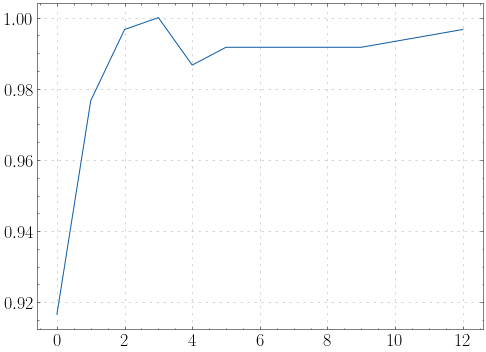

In [153]:
plt.plot(acc_train)

In [159]:
pd.crosstab(ds2_train.iloc[:,featvec_length],y_Pred)

col_0,0
col_1,0
col_2,0
col_3,0
col_4,0
col_5,0
col_6,0
col_7,0
col_8,0
col_9,2
col_10,0


In [30]:
ds2_test = pd.read_csv("dev2.csv", header = None)

In [41]:
X_cv,X_test,y_cv,y_test = train_test_split(ds2_test.iloc[:,:2],ds2_test.iloc[:,2], test_size=0.3, random_state=0)

In [32]:
acc_cv = []
for Q in range(len(q)):
    y_Pred = []
    for i in range(len(X_cv)):
        lst = []
        for j in range(featvec_length+1):
            lst.append(likelihood(X_cv.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
        y_Pred.append(lst.index(max(lst)))
        #print(y_Pred[i])
    acc_calc = accuracy.Confusion_matrix(y_Pred,y_cv)
    acc_cv.append(acc_calc.accuracy)


In [33]:
df = pd.DataFrame(list(zip(q,acc_cv)),columns=["Hyperparameter Value", "Accuracy"])
df.to_csv("acc1b_cv.csv")

In [25]:
acc_cv = pd.read_csv("acc1b_cv.csv",index_col=0)

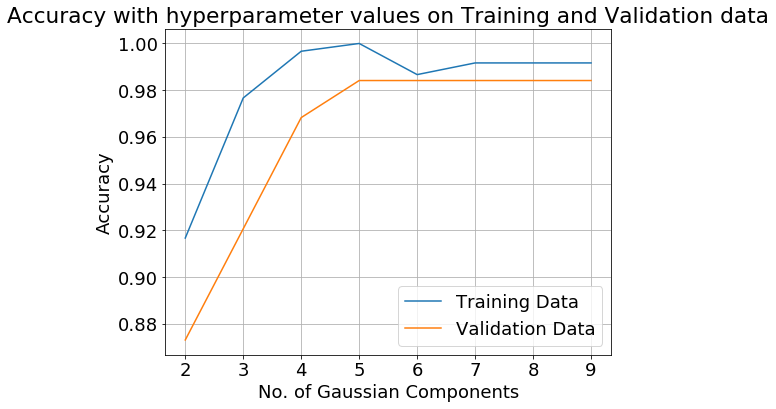

In [28]:
plt.plot(q,acc_train.iloc[:,1],label = "Training Data")
plt.plot(q,acc_cv.iloc[:,1],label = "Validation Data")
plt.xlabel("No. of Gaussian Components")
plt.ylabel("Accuracy")
plt.title("Accuracy with hyperparameter values on Training and Validation data")
plt.legend()
plt.savefig("acc_1b.png")
plt.show()

In [40]:
acc_cv.index(max(acc_cv))

3

In [41]:
q[3]

5

In [176]:
acc_train.index(max(acc_train))

3

In [42]:
# best model, q = 5
Q = 3
y_Pred = []
for i in range(len(X_test)):
    lst = []
    for j in range(featvec_length+1):
        lst.append(likelihood(X_test.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
    y_Pred.append(lst.index(max(lst)))
    #print(y_Pred[i])
acc_calc = accuracy.Confusion_matrix(y_Pred,y_test)
acc_test = acc_calc.accuracy


In [43]:
acc_test

1.0

In [35]:
Q=3
d=2
YPredTrain = []
for i in range(len(X_train)):
    lst = []
    for j in range(3):
        lst.append(likelihood(X_train.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
    YPredTrain.append(lst.index(max(lst)))

In [227]:
pd.DataFrame(YPredTrain).to_csv("YPredTrain.csv")
pd.DataFrame(YPredCV).to_csv("YPredCV.csv")
pd.DataFrame(YPredTest).to_csv("YPredTest.csv")
pd.DataFrame(yGridPred).to_csv("YPredGrid.csv")
pd.DataFrame(acc_cv).to_csv("acc_cv.csv")
pd.DataFrame(acc_train).to_csv("acc_train.csv")

In [43]:
YPredCV = []
for i in range(len(X_cv)):
    lst = []
    for j in range(3):
        lst.append(likelihood(X_cv.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
    YPredCV.append(lst.index(max(lst)))
    
YPredTest = []
for i in range(len(X_test)):
    lst = []
    for j in range(3):
        lst.append(likelihood(X_test.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
    YPredTest.append(lst.index(max(lst)))

In [36]:
import seaborn as sns

In [37]:
from sklearn.metrics import confusion_matrix

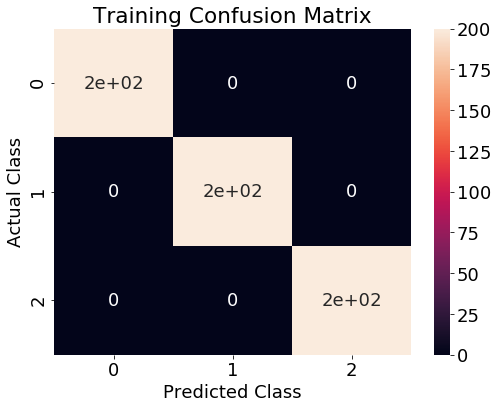

In [44]:
conf_mat = confusion_matrix(YPredTrain,Y_train)
plt.figure()
sns.heatmap(conf_mat, annot=True)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("conf_train1b.png")
plt.show()

In [48]:
conf_Train = ac_train.get_matrix()

In [50]:
pd.DataFrame(conf_Train).to_csv("conf_train_1b.csv")

In [52]:
ac_test = accuracy.Confusion_matrix(YPredTest,y_test)
conf_Test = ac_test.get_matrix()
pd.DataFrame(conf_Train).to_csv("conf_test_1b.csv")

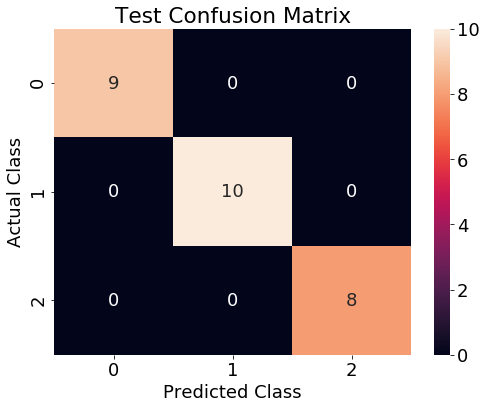

In [45]:
conf_mat = confusion_matrix(YPredTest,y_test)
plt.figure()
sns.heatmap(conf_mat, annot=True)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("conf_test1b.png")
plt.show()

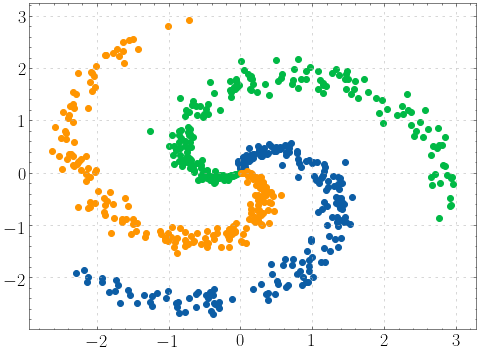

In [194]:
for class_val in range(3):
    row_idx = np.where(ds2_train.iloc[:,featvec_length]==class_val)
    plt.scatter(np.array(ds2_train)[row_idx,0],np.array(ds2_train)[row_idx,1])
plt.show()

In [32]:
Q = 3
d = 2

In [49]:
min_x1 = min(X_train[0])
max_x1 = max(X_train[0])
min_x2 = min(X_train[1])
max_x2 = max(X_train[1])

x1_range = np.linspace(min_x1,max_x1)
x2_range = np.linspace(min_x2,max_x2)

X1,X2 = np.meshgrid(x1_range,x2_range)

x1,x2 = X1.flatten(),X2.flatten()
x1,x2 = x1.reshape(len(x1),1),x2.reshape(len(x2),1)
grid = np.hstack((x1,x2))

In [33]:
yGridPred = []
for i in range(len(grid)):
    lst = []
    for j in range(3):
        lst.append(likelihood(grid[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
    yGridPred.append(lst.index(max(lst)))
yGridPred = np.array(yGridPred).reshape(X1.shape)

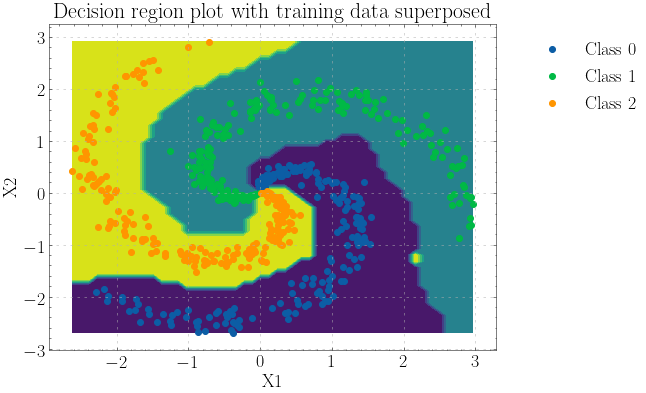

In [225]:
plt.contourf(X1,X2,yGridPred)
for class_val in range(3):
    row_idx = np.where(ds2_train.iloc[:,featvec_length]==class_val)
    plt.scatter(np.array(ds2_train)[row_idx,0],np.array(ds2_train)[row_idx,1],label = "Class "+ str(class_val))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Decision region plot with training data superposed")
plt.savefig("decisionReg_ds2.png")
plt.show()

In [20]:

Q=3
d=2
x, y = np.mgrid[-3:3:30j, -3:3:30j]
xy = np.column_stack([x.flat, y.flat])
z0_val = np.zeros(len(xy))
z1_val = np.zeros(len(xy))
z2_val = np.zeros(len(xy))

for i in range(len(xy)):
    lst = np.array((len(xy)))
    z0_val[i] = likelihood(xy[i],parameters[0][Q][0],parameters[0][Q][1],parameters[0][Q][2])
    z1_val[i] = likelihood(xy[i],parameters[1][Q][0],parameters[1][Q][1],parameters[1][Q][2])
    z2_val[i] = likelihood(xy[i],parameters[2][Q][0],parameters[2][Q][1],parameters[2][Q][2])
d = np.hstack((z0_val.reshape(900,-2),z1_val.reshape(900,-2),z2_val.reshape(900,-2)))
classes = np.argmax(d,axis=1)
classes = classes.reshape(x.shape)




NameError: name 'df' is not defined

<Figure size 576x432 with 0 Axes>

In [45]:
def gaussian_val(X_test,w,mu,C):
    n, d = X_test.shape
    val = np.zeros((n, 5))

    for i in range(5):
        val[:,i] = w[i]*mvn.pdf(X_test, mu.iloc[i], C[i])

    return np.sum(val, axis=1)

In [23]:
color_list = ["springgreen", "mediumturquoise", "palevioletred"]

In [46]:
z0 = np.zeros(len(xy))
z1 = np.zeros(len(xy))
z1 = np.zeros(len(xy))


z0 = gaussian_val(xy,parameters[0][Q][1],parameters[0][Q][0],parameters[0][Q][2])
z1 = gaussian_val(xy,parameters[1][Q][1],parameters[1][Q][0],parameters[1][Q][2])
z2 = gaussian_val(xy,parameters[2][Q][1],parameters[2][Q][0],parameters[2][Q][2])

z0 = z0.reshape(x.shape)


z1 = z1.reshape(x.shape)

z2 = z2.reshape(x.shape)

<Figure size 576x432 with 0 Axes>

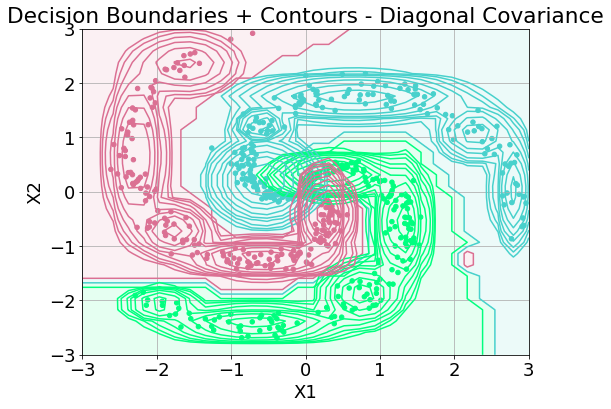

In [49]:
plt.figure()
ds2_train.plot.scatter(0, 1, c=[color_list[int(i)] for i in ds2_train[2]], alpha=1)
plt.contourf(x, y, classes, 2, colors=color_list, alpha=0.1)
plt.contour(x, y, classes, 2, colors=color_list, alpha=1)
plt.contour(x, y, z0, levels=np.logspace(-2,2,20), colors=color_list[0])
plt.contour(x, y, z1, levels=np.logspace(-2,2,20), colors=color_list[1])
plt.contour(x, y, z2, levels=np.logspace(-2,2,20), colors=color_list[2])
plt.title("Decision Boundaries + Contours - Diagonal Covariance")
plt.xlabel("X1")
plt.ylabel("X2")
plt.savefig("contour1b.png")
plt.show()
